This notebook is a bit of a crazy attempt to segment multiple bat calls in the time-domain using some of the methods developed in ```measure_horseshoe_bat_calls```

In [1]:
%matplotlib notebook

In [2]:
import measure_horseshoe_bat_calls
from measure_horseshoe_bat_calls.segment_horseshoebat_call import *
from measure_horseshoe_bat_calls.signal_processing import *
from measure_horseshoe_bat_calls.view_horseshoebat_call import *


In [3]:
from measure_horseshoe_bat_calls.measure_a_horseshoe_bat_call import make_one_CFcall

In [4]:
import scipy.signal as signal 
import soundfile as sf

First let's create some synthetic data to understand how well things might work:

In [5]:
help(make_one_CFcall)

Help on function make_one_CFcall in module measure_horseshoe_bat_calls.measure_a_horseshoe_bat_call:

make_one_CFcall(call_durn, fm_durn, cf_freq, fs, call_shape, **kwargs)
    A test function used to check how well the segmenting+measurement
    functions in the module work. 
    
    Parameters
    ----------
    call_durn : float
    fm_durn : float
    cf_freq : float
    fs : float
    call_shape : str
        One of either 'staplepin' OR 'rightangle'
    fm_bandwidth : float, optional
        FM bandwidth in Hz.
    
    Returns
    --------
    cfcall : np.array
        The synthesised call. 
    
    Raises
    -------
    ValueError
        If a call_shape that is not  'staplepin' OR 'rightangle' is given
    
    Notes
    ------
    This is not really the besssst kind of CF call to test the functions on, 
    but it works okay. The CF call is made by using the poly spline function 
    and this leads to weird jumps in frequency especially around the CF-FM
    junctions. Long

In [6]:
fs = 500000
call1 = make_one_CFcall(0.040, 0.005, 100000, fs, 'staplepin', fm_bandwidth=15000)


call2 = make_one_CFcall(0.040, 0.005, 105000, fs, 'staplepin', fm_bandwidth=5000)
call2 *= 10**(-10/20.0)

all_calls = [call1, call2]

call_start_times = [0.000, 0.010]

call12 = np.random.normal(0, 10**(-50/20.0), int(call_start_times[-1]*fs)+all_calls[-1].size)

for call_start,each_call in zip(call_start_times, all_calls):
    start_sample = int(call_start*fs)
    call12[start_sample:start_sample+each_call.size] += each_call


/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/measure_horseshoe_bat_calls/measure_a_horseshoe_bat_call.py:179: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(t, freqs, polynomial_num)
/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/measure_horseshoe_bat_calls/measure_a_horseshoe_bat_call.py:179: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(t, freqs, polynomial_num)


<IPython.core.display.Javascript object>


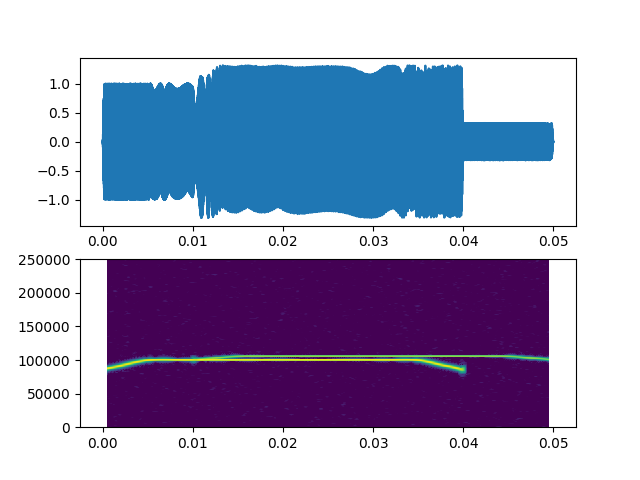

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0b63beed50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0b63be1f50>)

In [7]:
visualise_call(call12,fs)

### What does the power spectrum of this audio snippet look like?


In [8]:
power_spec, freqs = get_power_spectrum(call12, fs)

<IPython.core.display.Javascript object>


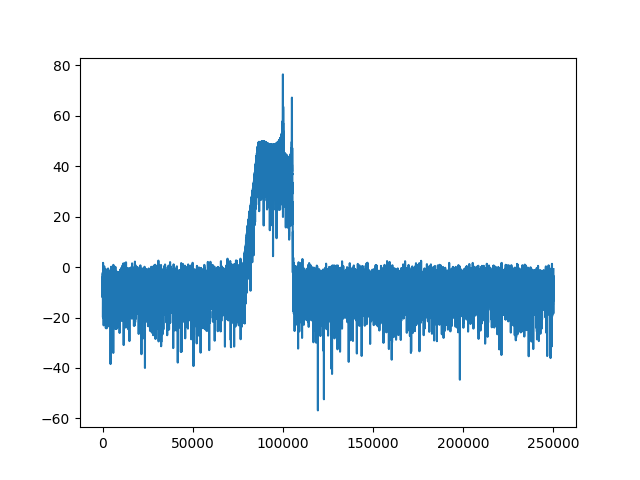

In [9]:
plt.figure()
plt.plot(freqs, power_spec)

A visual inspection suggests around 99kHz (am being approximate on purpose)

In [10]:
lp_a, hp_a = low_and_highpass_around_threshold(call12, fs, 99900)


/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [11]:
help(pre_process_for_segmentation)

Help on function pre_process_for_segmentation in module measure_horseshoe_bat_calls.segment_horseshoebat_call:

pre_process_for_segmentation(call, fs, **kwargs)
    Performs a series of steps on a raw cf call before passing it for temporal segmentation 
    into cf and fm. 
    Step 1: find peak frequency
    Step 2: lowpass (fm_audio) and highpass (cf_audio) below
            a fixed percentage of the peak frequency
    Step 3: calculate the moving dB  of the fm and cf audio
    
    Parameters
    -----------
    call : np.array
    fs : int.
        Frequency of sampling in Hertz
    peak_percentage : 0<float<1, optional
        This is the fraction of the peak at which low and high-pass filtering happens.
        Defaults to 0.98.
    lowpass : optional
        Custom lowpass filtering coefficients. See low_and_highpass_around_threshold
    highpass : 
        Custom highpass filtering coefficients. See low_and_highpass_around_threshold
    window_size : integer, optional
        T

In [12]:
cfdbrms, fmdbrms = pre_process_for_segmentation(call12, fs)

<IPython.core.display.Javascript object>


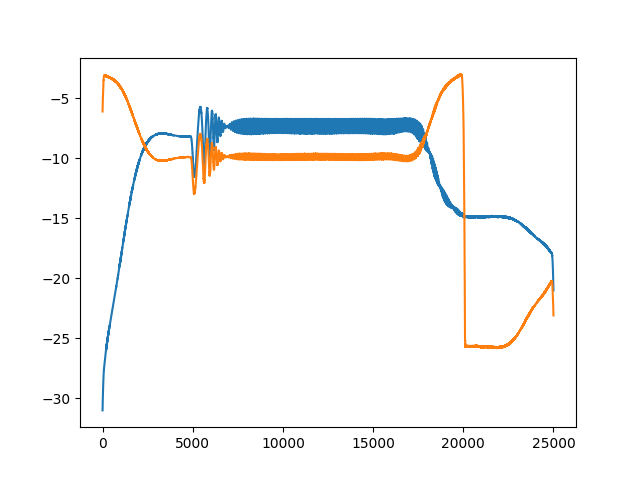

In [13]:
plt.figure()
plt.plot(cfdbrms)
plt.plot(fmdbrms)

In [14]:
cf_to_fm = cfdbrms-fmdbrms
cf_to_fm -= np.max(cf_to_fm)

fm_to_cf = -cf_to_fm
fm_to_cf -= np.max(fm_to_cf)

cf_regions = cf_to_fm >= 0
fm_regions = fm_to_cf >= 0

<IPython.core.display.Javascript object>


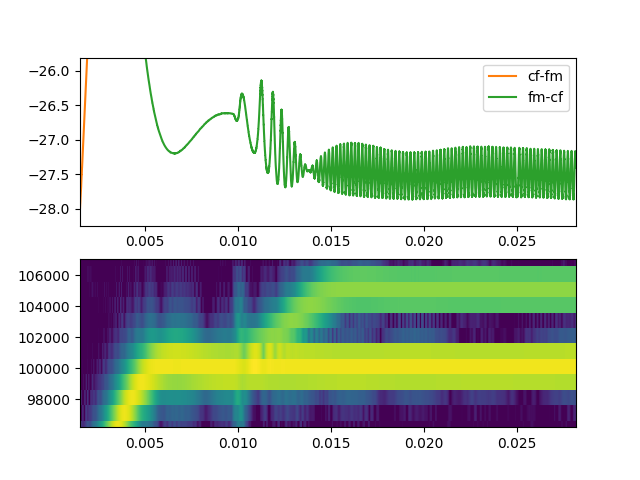

In [15]:
wave, spec = visualise_call(call12, fs)
wave.plot(make_x_time(cf_to_fm,fs), cf_to_fm, label='cf-fm')
wave.plot(make_x_time(cf_to_fm,fs), fm_to_cf, label='fm-cf')
#spec.plot(make_x_time(cf_regions,fs), cf_regions*80000)
wave.legend()

In [16]:
dir(measure_horseshoe_bat_calls.segment_horseshoebat_call)

['IncorrectThreshold',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__version_segment_hbc',
 'calc_energy',
 'calc_sound_borders',
 'dB',
 'form_consensus_moving_rms',
 'get_fm_regions',
 'get_peak_frequency',
 'get_power_spectrum',
 'get_robust_peak_frequency',
 'get_thresholds_re_max',
 'identify_maximum_contiguous_regions',
 'identify_valid_regions',
 'low_and_highpass_around_threshold',
 'moving_rms',
 'moving_rms_edge_robust',
 'np',
 'pre_process_for_segmentation',
 'pywt',
 'rms',
 'segment_call_from_background',
 'segment_call_into_cf_fm',
 'segment_cf_and_fm',
 'signal',
 'warnings']

In [17]:
help(get_thresholds_re_max)

Help on function get_thresholds_re_max in module measure_horseshoe_bat_calls.segment_horseshoebat_call:

get_thresholds_re_max(cf_dbrms, fm_dbrms)

